In [2]:
import sys
import pandas as pd
from pathlib import Path

# Add project root to Python path
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

In [3]:
import src.loadProcessed as loadp

counts = loadp.load_processed_count()
locations = loadp.load_processed_locations()

# Initial Exploration

In [4]:
import matplotlib.pyplot as plt
import matplotlib.axes
import matplotlib.dates

Text(0, 0.5, 'Count')

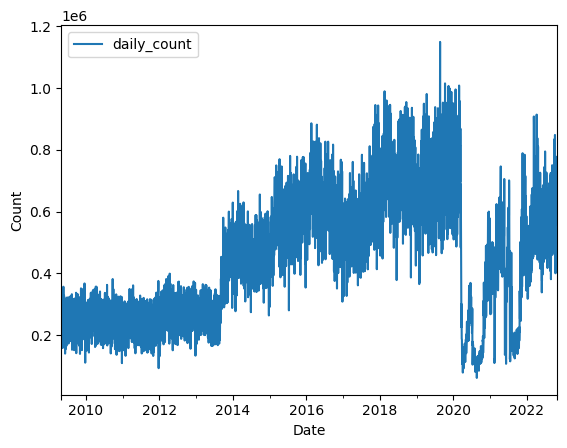

In [5]:
counts_by_sensor: pd.DataFrame = counts.groupby(counts['sensing_date'])['daily_count'].sum().reset_index()

ax: matplotlib.axes.Axes = counts_by_sensor.plot.line(
    x='sensing_date', y='daily_count',
)
ax.set_xlabel("Date")
ax.set_ylabel("Count")

I wanted to visualise how the number of counts changes over time. 
As we can see in the above plot, there is a general trend upwards. There are a few reasons for this I will need to explore. First of these is that more sensors are installed over time so we need to account for that, this will most likely involve treating sensors as categorical variables. Secondly, since I am most interested in the behaviour of the population, rather than the congestion of the city, I would like to account for the population size of melbourne as well as that has increased significantly over time.

In [6]:
counts_by_sensor: pd.DataFrame = (
    counts.groupby(
        ['sensor_id', 'sensing_date'], observed=True
    )['daily_count']                                                   # ['daily_count'] makes it a series with the multiindex as the index
    .sum()                                                  # So the sum just sums over the values (aggregates hourly_count per sensor x time combo)
    .unstack(level='sensor_id')                                        # Seperates out the multiindex to treat each sensor as a level, date makes up the new index
)


To make the initial analysis a bit easier, I'm going to focus on a single key sensor. Later in the process I'll reintroduce other sensors so that I can improve the power of my tests

Text(0.5, 1.0, 'Grattan St-Swanston St (West) Count highlighting 1st March (~start of sem 1)')

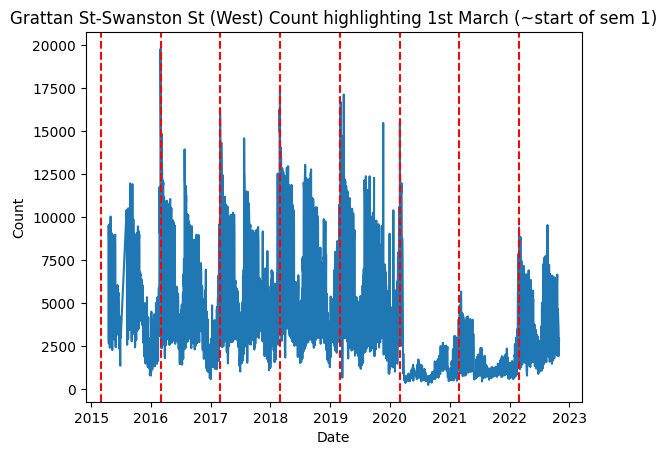

In [7]:
single_sensor_loc = locations[locations['sensor_name'] == 'UM1_T']

single_sensor_counts = pd.DataFrame.merge(
    single_sensor_loc, counts, how='inner', on='sensor_id'
)

fig, ax = plt.subplots()
ax.plot(single_sensor_counts['sensing_date'], single_sensor_counts['daily_count'], label='Daily Counts')

highlight_day, highlight_month = 1, 3 
for year in range(
    single_sensor_counts['sensing_date'].min().year,
    single_sensor_counts['sensing_date'].max().year + 1
):
    nye = pd.Timestamp(year=year, month=highlight_month, day=highlight_day)
    x_coord = float(matplotlib.dates.date2num(nye))

    ax.axvline(x_coord, color='red', linestyle='--')

ax.set_xlabel('Date')
ax.set_ylabel('Count')

ax.set_title(f'{single_sensor_loc['sensor_description'].item()} Count highlighting 1st March (~start of sem 1)')


I found that many sensor locations have a specific pattern of activity that aligns with events in that location. Pictured is near The University of Melbourne where we can see a clear correlation with the university semesters. We can see that there is a sharp peak at the start of semester, which slowly decreases as it gets later in semester. 

In other locations I saw other such yearly patters such as for the Australian Open finals, new years eve, or pre-christmas shopping.

I believe that many of these location specific variations will be ironed out later such that we can see the effect of covid on foot traffic.
We can see that the foot traffic was much lower during lockdowns in 2020 and 2021 and then does not quite recover afterwards, which is supporting my theory. However with the specific example above, this may be due to a change in university policy to allow for more online learning.

I found that the Spencer St-Collins St (North) sensor seemed to have a fairly stable pattern with few gaps in data so I will begin my analysis with that.

Text(0.5, 1.0, 'Spencer St-Collins St (North) counts')

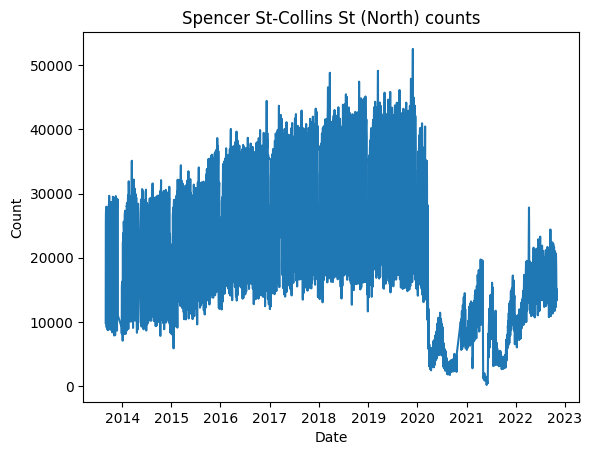

In [8]:
single_sensor_loc = locations[locations['sensor_name'] == 'Col620_T']

single_sensor_counts = pd.DataFrame.merge(
    single_sensor_loc[['sensor_id']], counts, how='inner', on='sensor_id'
).drop(columns=['sensor_id'])

fig, ax = plt.subplots()
ax.plot(single_sensor_counts['sensing_date'], single_sensor_counts['daily_count'], label='Daily Counts')

ax.set_xlabel('Date')
ax.set_ylabel('Count')

ax.set_title(f'{single_sensor_loc['sensor_description'].item()} counts')

Text(0.5, 1.0, 'Pedestrian Counts at Spencer St-Collins St (North) with covid stage 3 lockdowns shaded')

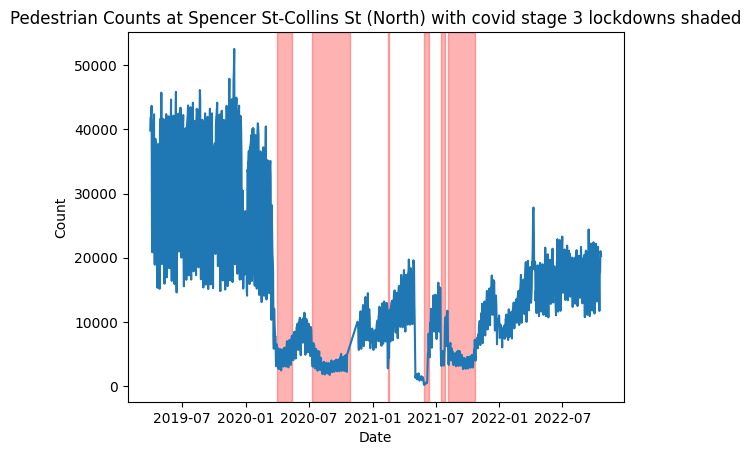

In [9]:
import src.config as config

# Taking timeslice from a year before first lockdown to year after last lockdown
counts_in_timeslice = (
    single_sensor_counts[
        (single_sensor_counts['sensing_date'] > (config.FIRST_LOCKDOWN_START - pd.Timedelta(days=365)))
        & (single_sensor_counts['sensing_date'] < (config.LAST_LOCKDOWN_END + pd.Timedelta(days=365)))
    ]
)

fig, ax = plt.subplots()
ax.plot(counts_in_timeslice['sensing_date'], counts_in_timeslice['daily_count'], label='Daily Counts')

for start, end in config.LOCKDOWN_DATES.itertuples(index=False):
    ax.axvspan(
        start, end,
        color='red',
        alpha=0.3
    )

ax.set_xlabel('Date')
ax.set_ylabel('Count')

ax.set_title('Pedestrian Counts at Spencer St-Collins St (North) with covid stage 3 lockdowns shaded')

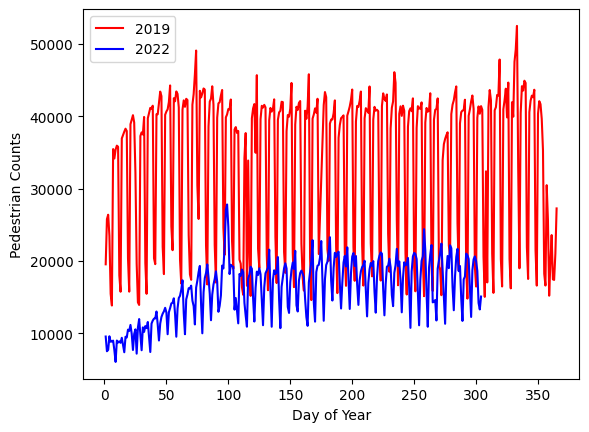

In [10]:
counts_2019 = (
    single_sensor_counts[
        single_sensor_counts['sensing_date'].dt.year == 2019
    ]
)

counts_2022 = (
    single_sensor_counts[
        single_sensor_counts['sensing_date'].dt.year == 2022
    ]
)

fig, ax = plt.subplots()
ax.plot(counts_2019['sensing_date'].dt.dayofyear, counts_2019['daily_count'], label='2019', color='red')
ax.plot(counts_2022['sensing_date'].dt.dayofyear, counts_2022['daily_count'], label='2022', color='blue')

ax.set_xlabel('Day of Year')
ax.set_ylabel('Pedestrian Counts')

ax.legend()

log(X) has mean 8.83990356253342 and variance 0.95711552718933
    with kurtosis -0.6991891921771343 and skew -0.039147882125830515


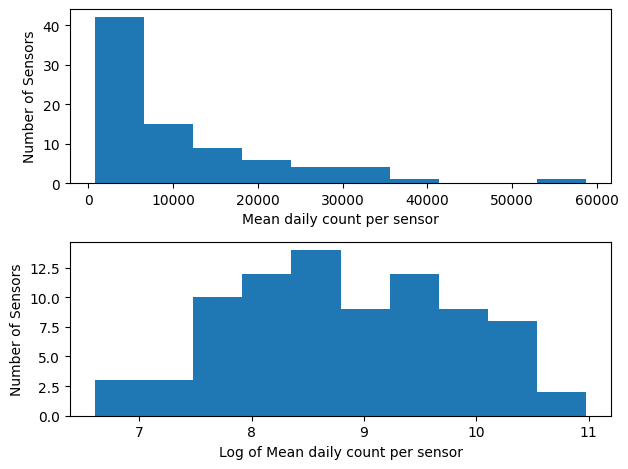

In [11]:
import math

sensor_averages = counts_by_sensor.mean()
fig, (ax_1, ax_2) = plt.subplots(2)
ax_1.hist(sensor_averages, 10)
ax_1.set_xlabel('Mean daily count per sensor')
ax_1.set_ylabel('Number of Sensors')

log_sensor_averages = sensor_averages.apply(lambda x: math.log(x))
ax_2.hist(log_sensor_averages, 10)
ax_2.set_xlabel('Log of Mean daily count per sensor')
ax_2.set_ylabel('Number of Sensors')

fig.tight_layout()

print(f'log(X) has mean {log_sensor_averages.mean().item()} and variance {log_sensor_averages.var().item()}\n    with kurtosis {log_sensor_averages.kurtosis().item()} and skew {log_sensor_averages.skew().item()}')

Plotting the daily sensor count (over the entirety of each sensor's readings rather than just 2019 and 2022) we can see that it follows an exponential trend with a significant right-skew. Taking the log of this, we see quite a convincing normal distribution, if a bit flat with a negative kurtosis. 

In [12]:
zero_counts = pd.merge(
    counts.query('daily_count == 0'), locations,
    how="inner", on='sensor_id'
)
zero_counts = (
    zero_counts[
        (zero_counts['sensing_date'].dt.year == 2019) | (zero_counts['sensing_date'].dt.year == 2022)
    ]
)

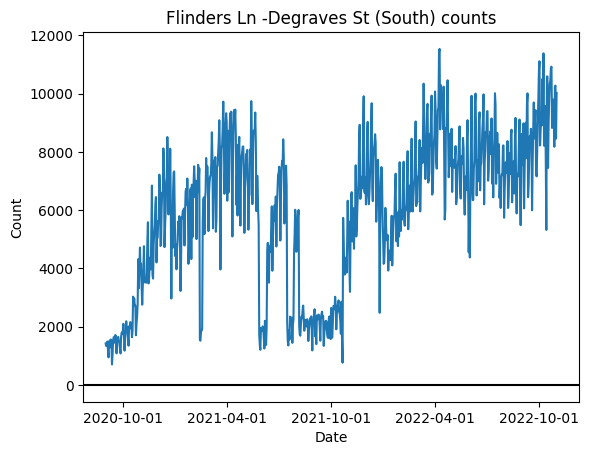

In [13]:
single_sensor_loc = locations[locations['sensor_id'] == 67]

single_sensor_counts = pd.DataFrame.merge(
    single_sensor_loc[['sensor_id']], counts, how='inner', on='sensor_id'
).drop(columns=['sensor_id'])


fig, ax = plt.subplots()
ax.plot(single_sensor_counts['sensing_date'], single_sensor_counts['daily_count'], label='Daily Counts')

ax.set_xlabel('Date')
ax.set_ylabel('Count')

ax.set_title(f'{single_sensor_loc['sensor_description'].item()} counts')
ax.set_xticks(ax.get_xticks()[::2])

zero_counts_single_sensor = single_sensor_counts[single_sensor_counts['daily_count'] == 0]
ax.scatter(
    zero_counts_single_sensor['sensing_date'], zero_counts_single_sensor['daily_count'],
    color='red'
)

ax.axhline(color='black')